## Install the package dependencies before running this notebook

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd

torch.manual_seed(0)

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
train_min = 0
train_dif = 1

val_min = 0
val_dif = 1

test_min = 0
test_dif = 1


def normalize(data):
    norm = np.linalg.norm(data)       # To find the norm of the array
    print(norm)                                # Printing the value of the norm
    normalized_array = data/norm  # Formula used to perform array normalization
    print(normalized_array)
    return normalized_array
    
# def denormalize():

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        # take 80% of input data for training set
        

        
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        if(normalized == True):
            global train_min
            global train_dif
            train_max = np.max(inputs, axis=1, keepdims = True)
            train_min = np.min(inputs, axis=1, keepdims = True)
            train_dif = train_max - train_min
            
            inputs = (inputs - train_min)/train_dif
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        # take 80% of output data for training set
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
#         if(normalized == True):
#             outputs = outputs/norm
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        # last 20% of input data for val set
        

        
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        if(normalized == True):
            global val_min
            global val_dif
            val_max = np.max(inputs, axis=1, keepdims = True)
            val_min = np.min(inputs, axis=1, keepdims = True)
            val_dif = val_max - val_min
            
            inputs = (inputs - val_min)/val_dif
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
        
#         if(normalized == True):
#             outputs = outputs/norm
    
    elif split == 'test':
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
        if(normalized == True):
            global test_min
            global test_dif
            test_max = np.max(inputs, axis=1, keepdims = True)
            test_min = np.min(inputs, axis=1, keepdims = True)
            test_dif = test_max - test_min
            
            inputs = (inputs - test_min)/test_dif
        
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    return inputs, outputs

# this is a custom dataset class
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data


In [42]:
from torch import nn, optim
# create a module
class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.linearRegression = nn.Sequential(
#             nn.BatchNorm1d(num_features=100),
            nn.Linear(100, 128),
#             nn.BatchNorm1d(num_features=20),
#             nn.ReLU(),
#             nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(64, 64),
            #nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(64, 120),
        )
        
    def forward(self, x):
        # stacks the y at the bottom of the x (puts the right 50 at the bottom)
        x = x.reshape(-1, 100).float()
        x = self.linearRegression(x)
        x = x.reshape(-1, 60, 2)
        return x

In [8]:
# train the model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def train(batch_sz, city, learningRate, num_epoches, plot_every, val_plot_every):
    if (city == "palo-alto"): 
        pred = palo_alto_pred
    elif (city == "austin"): 
        pred = austin_pred
    elif (city == "miami"): 
        pred = miami_pred
    elif (city == "pittsburgh"): 
        pred = pittsburgh_pred
    elif (city == "dearborn"): 
        pred = dearborn_pred
    elif (city == "washington-dc"): 
        pred = washington_pred
    
    train_dataset = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    
    
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    opt = optim.AdamW(pred.parameters(), lr=learningRate)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

    all_losses = []
    val_all_losses = [] 

    for epoch in range(num_epoches):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            # send input to model
            inp, out = sample_batch
            inp = inp.cuda()
            out = out.cuda()
            
            #make predictions and de-normalize
            global train_dif
            global train_min
            train_dif_b = train_dif[i_batch * batch_sz : (i_batch + 1) * batch_sz, :, :]
            train_min_b = train_min[i_batch * batch_sz : (i_batch + 1) * batch_sz, :, :]
            train_dif_b = torch.Tensor(train_dif_b).cuda()
            train_min_b = torch.Tensor(train_min_b).cuda()
            preds = pred(inp)
            
            preds = (preds * train_dif_b) + train_min_b
            
            
            
            # MSE Loss
            loss = ((preds - out) ** 2).sum()

            # update weight parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            # compute total loss to determine if loss decreases
            total_loss += loss.item()

        if epoch % plot_every == 0 and epoch != 0:
            all_losses.append(total_loss / len(train_dataset))

        val_loss = 0
        for i_val_batch, val_batch in enumerate(val_loader):

            inp_val, out_val = val_batch
            inp_val = inp_val.cuda()
            out_val = out_val.cuda() 
            
            
            global val_dif
            global val_min
            
            val_dif_b = val_dif[i_val_batch * batch_sz : (i_val_batch + 1) * batch_sz, :, :]
            val_min_b = val_min[i_val_batch * batch_sz : (i_val_batch + 1) * batch_sz, :, :]
            
            val_dif_b = torch.Tensor(val_dif_b).cuda()
            val_min_b = torch.Tensor(val_min_b).cuda()
            
            preds_val = pred(inp_val)
            preds_val = (preds_val * val_dif_b) + val_min_b


            loss_val = ((preds_val - out_val) ** 2).sum() # batch_sz = 4 x 60 x2

            # don't need to do backpropagation
            val_loss += loss_val.item()

        if epoch % val_plot_every == 0 and epoch != 0:
            val_all_losses.append(val_loss / len(val_dataset))            

        print('training: epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
        print('val: epoch {} loss: {}'.format(epoch, val_loss / len(val_dataset)))
        
        #scheduler.step()
        
    
    plt.figure()

    plt.plot(all_losses[4:], 'b')
    plt.plot(val_all_losses[4:], 'g')
#     print("preds inside train: ", preds)

In [9]:
# test the model
columns = ['ID','v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','v22','v23','v24','v25','v26','v27','v28','v29','v30','v31','v32','v33','v34','v35','v36','v37','v38','v39','v40','v41','v42','v43','v44','v45','v46','v47','v48','v49','v50','v51','v52','v53','v54','v55','v56','v57','v58','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v71','v72','v73','v74','v75','v76','v77','v78','v79','v80','v81','v82','v83','v84','v85','v86','v87','v88','v89','v90','v91','v92','v93','v94','v95','v96','v97','v98','v99','v100','v101','v102','v103','v104','v105','v106','v107','v108','v109','v110','v111','v112','v113','v114','v115','v116','v117','v118','v119']
df = pd.DataFrame(columns = columns)

def test(df_index, batch_sz, city):
    test_dataset = ArgoverseDataset(city = city, split = 'test') #size is 6325
    test_loader = DataLoader(test_dataset,batch_size=batch_sz)

    sample_i = 0 

#     df_final = pd.DataFrame(columns = columns)
    num_test_samples = {"austin" : 6325, "miami" : 7971, "pittsburgh" : 6361, "dearborn": 3671, "washington-dc":3829, "palo-alto":1686}
    print("city: ", city)
    if (city == "palo-alto"): 
        pred = palo_alto_pred
    elif (city == "austin"): 
        pred = austin_pred
    elif (city == "miami"): 
        pred = miami_pred
    elif (city == "pittsburgh"): 
        pred = pittsburgh_pred
    elif (city == "dearborn"): 
        pred = dearborn_pred
    elif (city == "washington-dc"): 
        pred = washington_pred
        
    for i_batch, sample_batch in enumerate(test_loader): #i_batch = 0 to 421
        inp, out = sample_batch
        inp = inp.cuda()
        out = out.cuda()
        
          #make predictions and de-normalize  
            
        global test_dif
        global test_min
        test_dif_b = test_dif[i_batch * batch_sz : (i_batch + 1) * batch_sz, :, :]
        test_min_b = test_min[i_batch * batch_sz : (i_batch + 1) * batch_sz, :, :]
        test_dif_b = torch.Tensor(test_dif_b).cuda()
        test_min_b = torch.Tensor(test_min_b).cuda()
        preds = pred(inp)

        preds = (preds * test_dif_b) + test_min_b      
        
        

        
        
        
        #send prds to csv
        last_iter = i_batch + batch_sz
        if (i_batch >= len(test_loader) - 1):
            last_iter = i_batch + ((num_test_samples[city] % batch_sz))

        batch_num = 0
        for i in range(i_batch,last_iter):
            
            id_name = str(sample_i) + "_" + city
            row = [id_name]
#             print('preds size: {}, sample_i: {}, i: {}, last_iter: {}, batch_Num: {}'.format(preds.size(), sample_i, i, last_iter, batch_num))
#             print(preds[batch_num])
#             r = preds[batch_num].reshape(120)
            for j in range(60):
                row.append(preds[batch_num][j][0].item())
                row.append(preds[batch_num][j][1].item())
            
            batch_num = (batch_num + 1) % batch_sz

            df.loc[df_index] = row
            sample_i += 1
            df_index += 1
            
    df.to_csv("./Submission/submission_linear_regression.csv", index=False)
#     print("DONE")
    return df_index

## Create a DataLoader class for training

### Austin

training: epoch 0 loss: 17773.361632108925
val: epoch 0 loss: 6564.161874270306
training: epoch 1 loss: 5865.7700885384975
val: epoch 1 loss: 5591.681622369991
training: epoch 2 loss: 5285.224446746259
val: epoch 2 loss: 5225.858927728867
training: epoch 3 loss: 5008.4212576230275
val: epoch 3 loss: 5001.419006992065
training: epoch 4 loss: 4810.9381125137625
val: epoch 4 loss: 4812.057469471312
training: epoch 5 loss: 4646.4739232809725
val: epoch 5 loss: 4655.38974729158
training: epoch 6 loss: 4508.706568226461
val: epoch 6 loss: 4513.205304295087
training: epoch 7 loss: 4388.870685677246
val: epoch 7 loss: 4386.1365067048655
training: epoch 8 loss: 4282.454365506695
val: epoch 8 loss: 4271.53123211224
training: epoch 9 loss: 4182.678934161418
val: epoch 9 loss: 4160.419312916761
training: epoch 10 loss: 4095.1456965985576
val: epoch 10 loss: 4069.397099271209
training: epoch 11 loss: 4019.8107793383997
val: epoch 11 loss: 3986.753479403356
training: epoch 12 loss: 3954.004363238494

training: epoch 101 loss: 3093.317680735231
val: epoch 101 loss: 3057.9920063404206
training: epoch 102 loss: 3091.9414552725807
val: epoch 102 loss: 3062.5366356013915
training: epoch 103 loss: 3088.3374814669405
val: epoch 103 loss: 3054.0078859971804
training: epoch 104 loss: 3086.4261485940797
val: epoch 104 loss: 3054.675902423952
training: epoch 105 loss: 3083.4493393833254
val: epoch 105 loss: 3053.805498783966
training: epoch 106 loss: 3079.96656564131
val: epoch 106 loss: 3053.133574648556
training: epoch 107 loss: 3076.874337205865
val: epoch 107 loss: 3051.357013058916
training: epoch 108 loss: 3074.2529900009886
val: epoch 108 loss: 3053.906697380477
training: epoch 109 loss: 3072.309135724097
val: epoch 109 loss: 3050.1998554643246
training: epoch 110 loss: 3067.863587427338
val: epoch 110 loss: 3048.402118645915
training: epoch 111 loss: 3066.3229517098193
val: epoch 111 loss: 3044.438059968364
training: epoch 112 loss: 3063.6888005031788
val: epoch 112 loss: 3044.4121927

training: epoch 199 loss: 2896.8571427982906
val: epoch 199 loss: 2942.805949478991
batch size: 20, lr: 0.00015, epoch:200


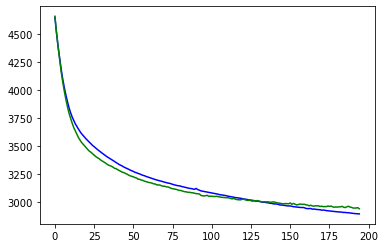

In [13]:
batch_sz = 20  # batch size 
# intialize a dataset
city = 'austin' 
learning_rate = 0.00015
num_epochs = 200 # should be 25

time = 0
plot_every = 1
val_plot_every = 1
austin_pred = Pred().to(device)
train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [14]:
#Two linear layers 128, 64 (Leaky RELu)
city = 'austin' 
df_index= 0
df_index = test(df_index, batch_sz, city)
print(df_index)

city:  austin
6325


### Miami

training: epoch 0 loss: 12320.567680953387
val: epoch 0 loss: 5326.129551472381
training: epoch 1 loss: 4817.96580782578
val: epoch 1 loss: 4552.083043886703
training: epoch 2 loss: 4321.23896470607
val: epoch 2 loss: 4199.410818090877
training: epoch 3 loss: 4055.883303246606
val: epoch 3 loss: 3962.1857195898483
training: epoch 4 loss: 3869.5859683862127
val: epoch 4 loss: 3794.0842433568296
training: epoch 5 loss: 3730.22621128487
val: epoch 5 loss: 3664.2371536949768
training: epoch 6 loss: 3616.6646226968014
val: epoch 6 loss: 3545.110652479079
training: epoch 7 loss: 3518.8793221750525
val: epoch 7 loss: 3435.8130749456805
training: epoch 8 loss: 3439.678732650234
val: epoch 8 loss: 3345.4902180892523
training: epoch 9 loss: 3376.7664314904305
val: epoch 9 loss: 3277.8898110578734
training: epoch 10 loss: 3325.0383219321557
val: epoch 10 loss: 3206.811814888274
training: epoch 11 loss: 3283.287681762708
val: epoch 11 loss: 3163.4664697906605
training: epoch 12 loss: 3250.38634750

training: epoch 101 loss: 2730.062210409005
val: epoch 101 loss: 2644.2100865684106
training: epoch 102 loss: 2727.42005602444
val: epoch 102 loss: 2643.363833796029
training: epoch 103 loss: 2726.2401212614923
val: epoch 103 loss: 2646.665000088117
training: epoch 104 loss: 2723.451913986189
val: epoch 104 loss: 2643.9944679648934
training: epoch 105 loss: 2721.354943082309
val: epoch 105 loss: 2646.5790840121776
training: epoch 106 loss: 2721.35188022914
val: epoch 106 loss: 2651.5302673714286
training: epoch 107 loss: 2717.4150012070454
val: epoch 107 loss: 2650.997382915047
training: epoch 108 loss: 2716.8794692911297
val: epoch 108 loss: 2641.538493981048
training: epoch 109 loss: 2714.4844929860346
val: epoch 109 loss: 2647.035496191991
training: epoch 110 loss: 2713.638159841274
val: epoch 110 loss: 2653.3614950953756
training: epoch 111 loss: 2711.4563093978936
val: epoch 111 loss: 2640.2852486972824
training: epoch 112 loss: 2709.641004592779
val: epoch 112 loss: 2648.44130324

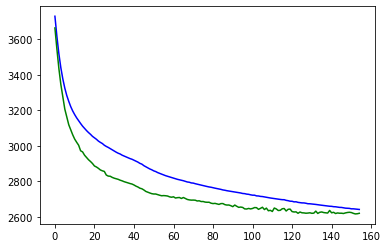

In [16]:
batch_sz = 20  # batch size 
# intialize a dataset
city = 'miami' 
learning_rate = 0.00015
num_epochs = 160
# num_epoches = 1

plot_every = 1
val_plot_every = 1
miami_pred = Pred().to(device)
train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [17]:
#Two linear layers 128, 64 (RELu)
city = 'miami' 
df_index = test(df_index, batch_sz, city)
print(df_index)

city:  miami
14296


### Pittsburgh

training: epoch 0 loss: 12925.206501738781
val: epoch 0 loss: 4901.294285907762
training: epoch 1 loss: 4518.038461458618
val: epoch 1 loss: 4236.480623324504
training: epoch 2 loss: 4155.4285561958695
val: epoch 2 loss: 3987.906241861474
training: epoch 3 loss: 3963.532156740425
val: epoch 3 loss: 3828.2132037557762
training: epoch 4 loss: 3831.5128285161427
val: epoch 4 loss: 3706.54847194299
training: epoch 5 loss: 3725.5326682411383
val: epoch 5 loss: 3603.0401826075413
training: epoch 6 loss: 3637.8669569346707
val: epoch 6 loss: 3512.756860504927
training: epoch 7 loss: 3563.1164040825042
val: epoch 7 loss: 3438.770220628181
training: epoch 8 loss: 3499.601110619622
val: epoch 8 loss: 3380.089775772564
training: epoch 9 loss: 3446.8837770121736
val: epoch 9 loss: 3330.8831988315587
training: epoch 10 loss: 3402.563570151812
val: epoch 10 loss: 3289.4975257254323
training: epoch 11 loss: 3365.590198238655
val: epoch 11 loss: 3255.2231670088304
training: epoch 12 loss: 3334.3556798

training: epoch 101 loss: 2794.440199705579
val: epoch 101 loss: 2789.2156477132253
training: epoch 102 loss: 2792.043305842144
val: epoch 102 loss: 2793.9449445016958
training: epoch 103 loss: 2789.4449409333124
val: epoch 103 loss: 2784.535339428303
training: epoch 104 loss: 2787.2793498891047
val: epoch 104 loss: 2786.48322018157
training: epoch 105 loss: 2785.614059897444
val: epoch 105 loss: 2786.720301784601
training: epoch 106 loss: 2782.921494599451
val: epoch 106 loss: 2780.0458612065113
training: epoch 107 loss: 2780.157153782884
val: epoch 107 loss: 2777.9674168290458
training: epoch 108 loss: 2778.8815403120866
val: epoch 108 loss: 2777.366839878562
training: epoch 109 loss: 2776.098918509477
val: epoch 109 loss: 2781.8067684368366
training: epoch 110 loss: 2774.0474997489996
val: epoch 110 loss: 2773.9173901318068
training: epoch 111 loss: 2772.6402709250046
val: epoch 111 loss: 2780.9330480428366
training: epoch 112 loss: 2770.700897251059
val: epoch 112 loss: 2783.556164

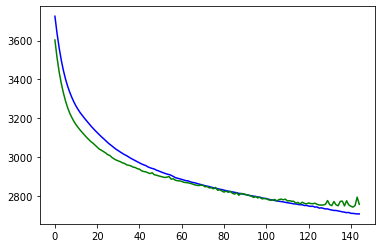

In [18]:
batch_sz = 20  # batch size 
# intialize a dataset
city = 'pittsburgh' 
learning_rate = 0.0002
num_epochs = 150

plot_every = 1
val_plot_every = 1
pittsburgh_pred = Pred().to(device)
train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [19]:
#Two linear layers 128, 64D (RELu)
city = "pittsburgh"
df_index = test(df_index, batch_sz, city)
print(df_index)

city:  pittsburgh
20657


### Dearborn

training: epoch 0 loss: 16926.23009102782
val: epoch 0 loss: 6947.921699328886
training: epoch 1 loss: 6599.79447332828
val: epoch 1 loss: 5720.63710398898
training: epoch 2 loss: 5916.485850985283
val: epoch 2 loss: 5609.464137148252
training: epoch 3 loss: 5637.121940819605
val: epoch 3 loss: 5596.323582135878
training: epoch 4 loss: 5458.99101658419
val: epoch 4 loss: 5596.477007561612
training: epoch 5 loss: 5327.551205826492
val: epoch 5 loss: 5627.640179209141
training: epoch 6 loss: 5220.149485471982
val: epoch 6 loss: 5640.208810244105
training: epoch 7 loss: 5131.411744563237
val: epoch 7 loss: 5650.560428774657
training: epoch 8 loss: 5050.8103362941065
val: epoch 8 loss: 5580.7060351328455
training: epoch 9 loss: 4975.520712641873
val: epoch 9 loss: 5630.243241815383
training: epoch 10 loss: 4903.711850495511
val: epoch 10 loss: 5529.6444865449785
training: epoch 11 loss: 4854.879567479977
val: epoch 11 loss: 5508.550516074853
training: epoch 12 loss: 4788.601459220338
val: 

training: epoch 101 loss: 3875.1282948092794
val: epoch 101 loss: 3700.3125094751217
training: epoch 102 loss: 3868.6278360324336
val: epoch 102 loss: 3688.5840113824115
training: epoch 103 loss: 3865.6415736360314
val: epoch 103 loss: 3707.2191188455004
training: epoch 104 loss: 3872.1708125959935
val: epoch 104 loss: 3691.8241417547165
training: epoch 105 loss: 3848.084935230804
val: epoch 105 loss: 3705.316890744337
training: epoch 106 loss: 3858.1781501603473
val: epoch 106 loss: 3686.432195197173
training: epoch 107 loss: 3853.829560829439
val: epoch 107 loss: 3690.681784664699
training: epoch 108 loss: 3858.6939908825084
val: epoch 108 loss: 3654.411966268389
training: epoch 109 loss: 3843.702873233997
val: epoch 109 loss: 3691.9554706314516
training: epoch 110 loss: 3854.2696691124506
val: epoch 110 loss: 3666.75312200199
training: epoch 111 loss: 3850.4380495480746
val: epoch 111 loss: 3683.9398604325415
training: epoch 112 loss: 3853.3224785640273
val: epoch 112 loss: 3678.546

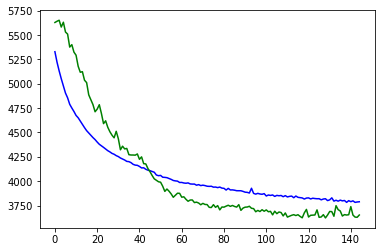

In [32]:
batch_sz = 30  # batch size 
# intialize a dataset
city = 'dearborn' 
learning_rate = 0.0015
num_epochs = 150

plot_every = 1
val_plot_every = 1
dearborn_pred = Pred().to(device)
train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [33]:
#one linear layer, 64, RELu
city = 'dearborn'
df_index = test(df_index, batch_sz, city)
print(df_index)

city:  dearborn
24328


### Washington DC

training: epoch 0 loss: 38875.916520479645
val: epoch 0 loss: 8941.834289617174
training: epoch 1 loss: 8041.854582400137
val: epoch 1 loss: 7766.034592392457
training: epoch 2 loss: 7047.1813807196095
val: epoch 2 loss: 6874.711834444797
training: epoch 3 loss: 6232.706189069741
val: epoch 3 loss: 6151.614879422849
training: epoch 4 loss: 5656.1626066218205
val: epoch 4 loss: 5674.9415729520515
training: epoch 5 loss: 5287.160520607088
val: epoch 5 loss: 5353.858154237678
training: epoch 6 loss: 5034.104793495268
val: epoch 6 loss: 5121.228430194476
training: epoch 7 loss: 4845.86488004225
val: epoch 7 loss: 4942.5306254702355
training: epoch 8 loss: 4697.589377121956
val: epoch 8 loss: 4800.194172338239
training: epoch 9 loss: 4576.800412104637
val: epoch 9 loss: 4684.265374850331
training: epoch 10 loss: 4476.552685297022
val: epoch 10 loss: 4589.137455792565
training: epoch 11 loss: 4392.43557428253
val: epoch 11 loss: 4509.595050732123
training: epoch 12 loss: 4321.390048728771
va

training: epoch 101 loss: 3234.2065771821103
val: epoch 101 loss: 3385.664782506347
training: epoch 102 loss: 3231.7813596379747
val: epoch 102 loss: 3382.35088379029
training: epoch 103 loss: 3229.1124022580307
val: epoch 103 loss: 3379.4088317332075
training: epoch 104 loss: 3226.371977026352
val: epoch 104 loss: 3376.936201195576
training: epoch 105 loss: 3224.3280153660803
val: epoch 105 loss: 3375.365999770924
training: epoch 106 loss: 3221.629134377823
val: epoch 106 loss: 3372.728450456544
training: epoch 107 loss: 3219.560638675413
val: epoch 107 loss: 3369.6405995661567
training: epoch 108 loss: 3217.4368577915698
val: epoch 108 loss: 3368.0579848058383
training: epoch 109 loss: 3214.99159546099
val: epoch 109 loss: 3364.229609195983
training: epoch 110 loss: 3212.675313411767
val: epoch 110 loss: 3361.604155552864
training: epoch 111 loss: 3210.339320175846
val: epoch 111 loss: 3359.6472792328286
training: epoch 112 loss: 3208.302352009175
val: epoch 112 loss: 3357.0611893055

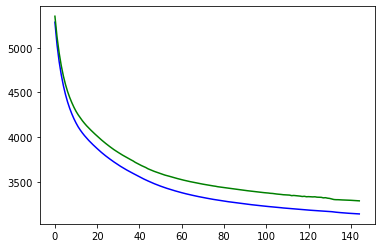

In [35]:
batch_sz = 30  # batch size 
# intialize a dataset
city = "washington-dc" 
learning_rate = 0.00015
num_epochs = 150

plot_every = 1
val_plot_every = 1
washington_pred = Pred().to(device)
train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [36]:
#one linear layer 64, leakyRElu
city = "washington-dc"
df_index = test(df_index, batch_sz, city)
print(df_index)

city:  washington-dc
28157


### Palo Alto

training: epoch 0 loss: 36879.40995192796
val: epoch 0 loss: 9232.07070219533
training: epoch 1 loss: 7718.4521373049565
val: epoch 1 loss: 7714.915686949675
training: epoch 2 loss: 6700.626011162755
val: epoch 2 loss: 7160.963329483221
training: epoch 3 loss: 6222.733865977613
val: epoch 3 loss: 6772.780899194761
training: epoch 4 loss: 5963.999442499336
val: epoch 4 loss: 6494.4644569553075
training: epoch 5 loss: 5776.350420783868
val: epoch 5 loss: 6249.292510812479
training: epoch 6 loss: 5644.794256169891
val: epoch 6 loss: 6091.641331136932
training: epoch 7 loss: 5523.081405241721
val: epoch 7 loss: 5937.140853630722
training: epoch 8 loss: 5418.41529347103
val: epoch 8 loss: 5789.354521061378
training: epoch 9 loss: 5327.570536643347
val: epoch 9 loss: 5650.818235474532
training: epoch 10 loss: 5229.350037097238
val: epoch 10 loss: 5495.045702633686
training: epoch 11 loss: 5125.073419542108
val: epoch 11 loss: 5284.752818242817
training: epoch 12 loss: 5021.584984329435
val: 

training: epoch 101 loss: 3684.9470882376486
val: epoch 101 loss: 3754.3312483550317
training: epoch 102 loss: 3690.5952531973585
val: epoch 102 loss: 3791.462857458946
training: epoch 103 loss: 3673.7077714762904
val: epoch 103 loss: 3805.521908428638
training: epoch 104 loss: 3687.718557725557
val: epoch 104 loss: 3790.1481305160173
training: epoch 105 loss: 3689.6173478943247
val: epoch 105 loss: 3815.440577513867
training: epoch 106 loss: 3631.9373937162336
val: epoch 106 loss: 3783.7324946654703
training: epoch 107 loss: 3657.430662327136
val: epoch 107 loss: 3756.446776683206
training: epoch 108 loss: 3635.0621551062864
val: epoch 108 loss: 3764.197608730013
training: epoch 109 loss: 3637.3054817741195
val: epoch 109 loss: 3819.3557817379037
training: epoch 110 loss: 3626.0099310869796
val: epoch 110 loss: 3773.1835698000527
training: epoch 111 loss: 3623.792744113925
val: epoch 111 loss: 3797.853908696197
training: epoch 112 loss: 3607.3899891383517
val: epoch 112 loss: 3749.216

training: epoch 199 loss: 3323.5000411650435
val: epoch 199 loss: 3440.133293118696
training: epoch 200 loss: 3321.2716331551237
val: epoch 200 loss: 3463.1325303404715
training: epoch 201 loss: 3329.020730492105
val: epoch 201 loss: 3469.1705462550162
training: epoch 202 loss: 3326.1296434567175
val: epoch 202 loss: 3489.483981305246
training: epoch 203 loss: 3309.2398144877147
val: epoch 203 loss: 3467.10927973721
training: epoch 204 loss: 3329.4547384597067
val: epoch 204 loss: 3505.5751112730463
training: epoch 205 loss: 3318.130014313225
val: epoch 205 loss: 3418.7653183471375
training: epoch 206 loss: 3301.508890710416
val: epoch 206 loss: 3405.0869002935456
training: epoch 207 loss: 3317.027068244462
val: epoch 207 loss: 3482.271426792977
training: epoch 208 loss: 3301.72318302508
val: epoch 208 loss: 3421.9724427231836
training: epoch 209 loss: 3306.322051982038
val: epoch 209 loss: 3416.81632141697
training: epoch 210 loss: 3314.7601691817504
val: epoch 210 loss: 3410.22919296

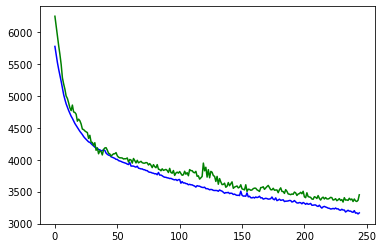

In [43]:
batch_sz = 60  # batch size 
# intialize a dataset
city = 'palo-alto' 
learning_rate = 0.001
num_epochs = 250 # should be 30


plot_every = 1
val_plot_every = 1
palo_alto_pred = Pred().to(device)

train(batch_sz, city, learning_rate, num_epochs, plot_every, val_plot_every)
print('batch size: {}, lr: {}, epoch:{}'.format(batch_sz, learning_rate, num_epochs))

In [44]:
#two linear layers 128, 64. RELu
city = "palo-alto"
df_index = test(df_index, batch_sz, city) # Palo alto has 1685
print(df_index)

city:  palo-alto
29843


## References: 
- Discussion week 7 code